In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
sns.set_style('darkgrid')

# Introduction
In this notebook, a linear regression model is trained to predict admissions chances given a number of metrics. The data used is from the citation below and is available [here](https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?datasetId=14872&sortBy=voteCount). The dataset was built to help Indian students specifically, thus the inclusion of a TOEFL score feature.

Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019

# Loading Data

In [40]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [41]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


At first glance, the Serial No. feature seems to possibly just be the index. If so, it will be removed.

In [42]:
# Will output if the Serial No. feature is different than index
different_idxs = []
for i in range(1, df.shape[0]+1):
    if i != df['Serial No.'].values[i-1]:
        print(i, df['Serial No.'].values[i-1])
        different_idxs.append(i)

# Drops Serial No. feature if not distinct from the index
if len(different_idxs) > 0:
    print('Keeping Serial No.')
else:
    print('Dropping Serial No.')
    df.drop('Serial No.', errors='ignore', inplace=True, axis=1)

Dropping Serial No.


In [43]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


# Data Cleaning
Data cleaning consists of checking for missing values and removing whitespace from feature names.

## Check for NaNs

In [44]:
df.isnull().values.any()

False

The data does not contain any NaNs. I will continue looking for outliers during EDA.

## Feature Names
There is whitespace in some feature names, which is removed.

In [45]:
print('Features before stripping whitepsace:')
print(df.columns)

df.columns = [title.strip() for title in df.columns]

print('Features after stripping whitespace')
print(df.columns)

Features before stripping whitepsace:
Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')
Features after stripping whitespace
Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')


# Exploratory Data Analysis

The data consists of the following features:
* GRE Scores (260 to 340)
* TOEFL (Test of English as a Foreign Language) Scores (0 to 120)
* University Rating (out of 5)
* Statement of Purpose (SOP) strength (out of 5)
* Letter of Recommendation (LOR) strength (out of 5)
* Undergraduate GPA (out of 10)
* Research Experience (either 0 or 1)
* Chance of Admit (ranging from 0 to 1)

Each of these features are either continuous or ordinal.

# Histograms

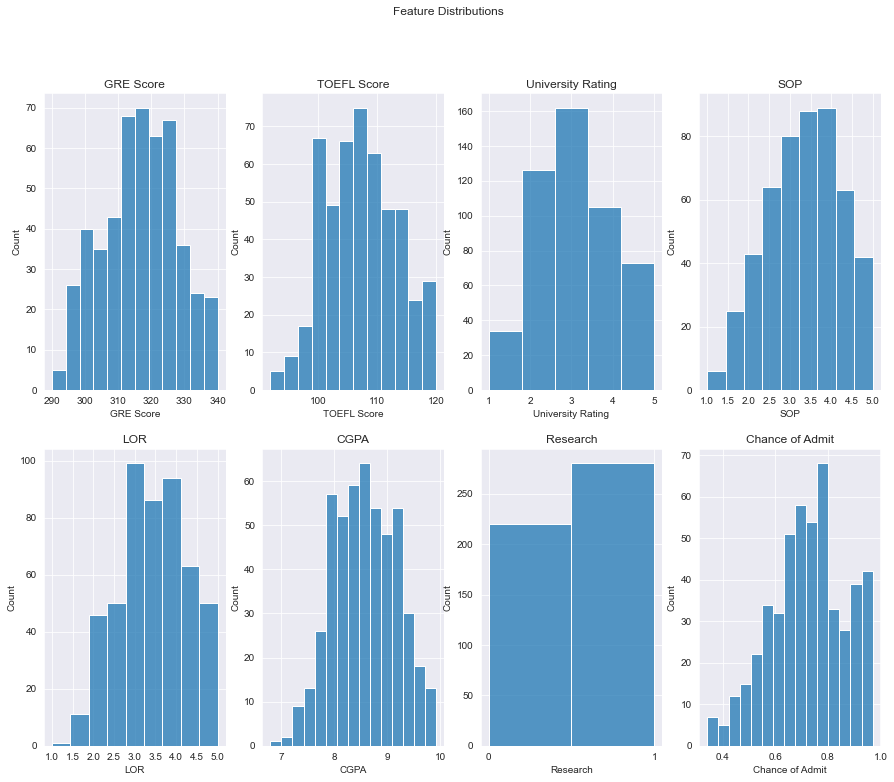

In [46]:
fig, axes = plt.subplots(2, 4, figsize = (15, 12))


sns.histplot(data=df, x='GRE Score', ax = axes[0][0])
axes[0][0].set_title('GRE Score')

sns.histplot(data=df, x='TOEFL Score', bins=12, ax = axes[0][1])
axes[0][1].set_title('TOEFL Score')

sns.histplot(data=df, x='University Rating', bins=5, ax = axes[0][2])
axes[0][2].set_title('University Rating')

sns.histplot(data=df, x='SOP', bins=9, ax = axes[0][3])
axes[0][3].set_title('SOP')
axes[0][3].set_xticks(np.linspace(1, 5, 9))

sns.histplot(data=df, x='LOR', bins=9,  ax = axes[1][0])
axes[1][0].set_title('LOR')
axes[1][0].set_xticks(np.linspace(1, 5, 9))


sns.histplot(data=df, x='CGPA', bins=15, ax = axes[1][1])
axes[1][1].set_title('CGPA')

sns.histplot(data=df, x='Research', bins=2, ax = axes[1][2])
axes[1][2].set_title('Research')
axes[1][2].set_xticks([0, 1])

sns.histplot(data=df, x='Chance of Admit', bins=15, ax = axes[1][3])
axes[1][3].set_title('Chance of Admit')

plt.suptitle('Feature Distributions')

plt.show()

From this plot, we can immediately conclude that the data should be scaled such that the features have mean = 0 and std = 1. Additionally, there are "missing" values in the Statement of Purpose and Letter of Recommendation features.

## Correlations and Bivariate Plots

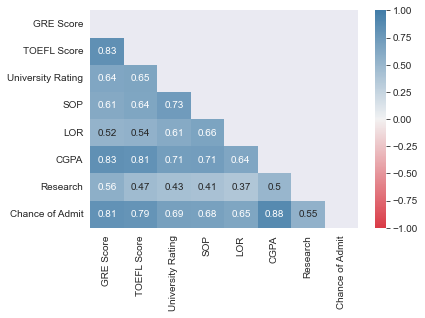

In [27]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
div_cmap = sns.diverging_palette(h_neg=10, h_pos=240, n=9, as_cmap=True)

sns.heatmap(data=corr, annot=True, vmin=-1, vmax=1, cmap=div_cmap, mask=mask)
plt.show()

All of the features have non-trivial correlations with the Chance of Admission - as one would hope that would. There are strong correlations (coefficient > 0.8) between the following features and the Chance of Admission:
* GRE Score
* CGPA

Additionally, the data raises multilinearity concerns, as there are significant correlations between features. Specifically, there are strong correlations between:
* TOEFL Score and GRE Score
* CGPA and GRE Score
* CGPA and TOEFL Score

## Plots

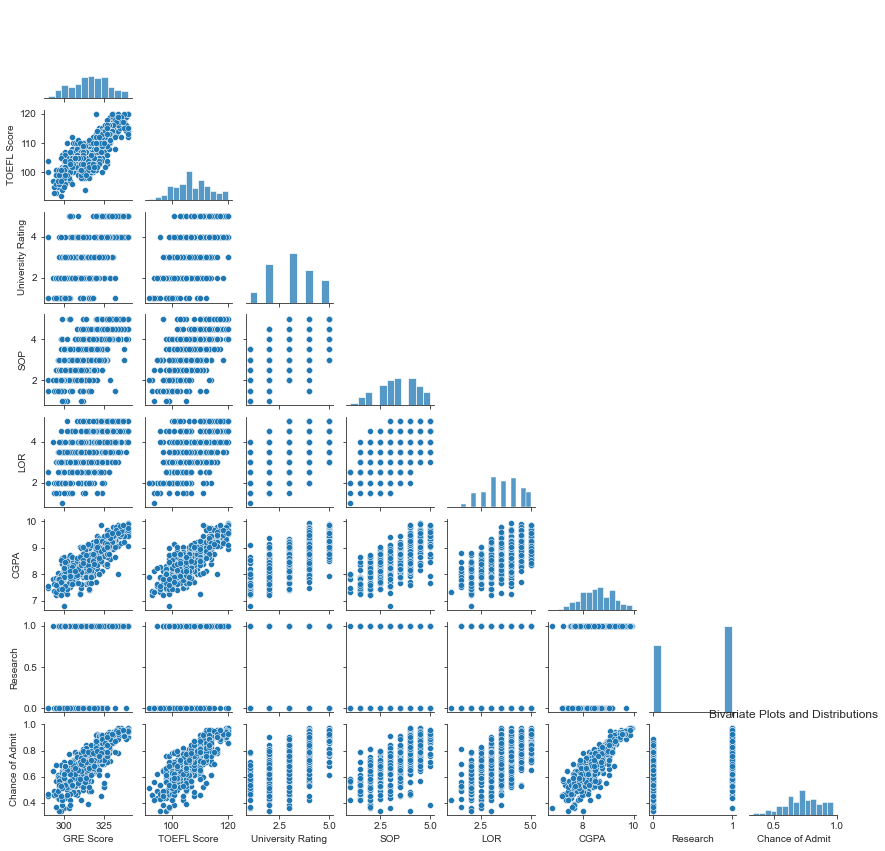

In [49]:
with sns.axes_style("ticks"):
    g = sns.pairplot(data=df, corner=True, height=1.5)

plt.title('Bivariate Plots and Distributions')
plt.show()

Considering only the bivariate plots, it appears that the relationship between most of the features is linear or close to it. Relationships between the Research feature and other features are an exception, but these are explained by the fact that Research is a binary feature.

# Training Model
Below an ElasticNet model is trained. The choice of model is discussed further below. Note that the model is not trained on all of the features in the dataset; "Research" was excluded after finding empirically that incuding it made overfitting more likely without a substantial increase in performance. Additionally, the Chance of Admission is cubed before fitting the model as this was found to improve the residual plot somewhat. The latter point is discussed in the evaluation section.

In [29]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [30]:
# Split data into train and test sets
features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA']
y = df.pop('Chance of Admit')
X = df[features]

y = y**3

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)

## Choosing Hyperparameters
The initial choice for a model is ElasticNet. ElasticNet is essentially a mix between Ridge Regression and LASSO regression. The hyperparameters to tune are l1_ratio and alpha. The l1_ratio parameter, which takes values between 0 and 1, is the relative strength of L1 regularization. When l1_ratio = 1, the model only uses L1 regularization and is equivalent to ridge regression when l1_ratio = 0, the model only uses L2 regularization and is equivalent to a LASSO model. The alpha parameter, which takes values alpha $\ge$ 0 is the strength of overall regularization. When alpha = 0, the model uses neither L1 nor L2 regularization and is equivalent to an ordinary linear regression model. When alpha > 0, the model uses whatever mixture of L1 and L2 regularization is chosen by l1_ratio.

In short, exhaustive cross validation using ElasticNet tests not only mixtures of L1 and L2 regularization but also Ridge Regression, LASSO, and ordinary linear regression.

### Preliminary Visualizations

Text(0.5, 0, 'Alpha')

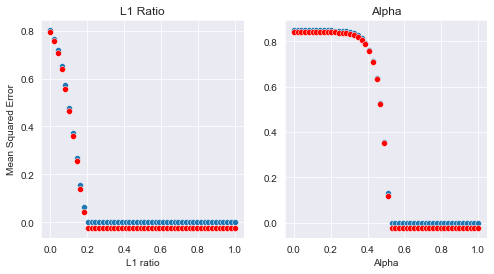

In [31]:
# Quick l1 ratio visualization
ratio_train_scores = []
ratio_test_scores = []

alpha_train_scores = []
alpha_test_scores = []

# Start l1_ratio with 0 + delta to avoid errors
l1_ratio_range = np.linspace(10e-10,1)
alpha_range = np.logspace(-3, 2)

for l1_ratio in l1_ratio_range:
    en = ElasticNet(alpha=1, l1_ratio=l1_ratio)
    en.fit(x_train_scaled, y_train)
    ratio_train_scores.append(r2_score(y_train, en.predict(x_train_scaled)))
    ratio_test_scores.append(r2_score(y_test, en.predict(x_test_scaled)))

for alpha in alpha_range:
    en = ElasticNet(alpha=alpha, l1_ratio=0.5)
    en.fit(x_train_scaled, y_train)
    alpha_train_scores.append(r2_score(y_train, en.predict(x_train_scaled)))
    alpha_test_scores.append(r2_score(y_test, en.predict(x_test_scaled)))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.scatterplot(x=l1_ratio_range, y=ratio_train_scores, ax=axes[0])
sns.scatterplot(x=l1_ratio_range, y=ratio_test_scores, color='red', ax=axes[0])
axes[0].set_title('L1 Ratio')
axes[0].set_xlabel('L1 ratio')
axes[0].set_ylabel('Mean Squared Error')

sns.scatterplot(x=l1_ratio_range, y=alpha_train_scores, ax=axes[1])
sns.scatterplot(x=l1_ratio_range, y=alpha_test_scores, color='red', ax=axes[1])
axes[1].set_title('Alpha')
axes[1].set_xlabel('Alpha')


The above plot suggests that for constant alpha, the model performs well with a low l1_ratio; however, concerns about overfitting suggest that a simple ridge regression model may overfit. For a constant l1_ratio, the model performs best with a low alpha; however overfitting concerns suggest that alpha should not be 0.  This will be further tested with cross validation.

### Cross Validation

In [32]:
l1_ratio_range = np.linspace(10e-8, 1)
alpha_range = np.logspace(-3, 1)
#alpha_range = np.linspace(0.4, 1)
en = ElasticNet(random_state=123)

params = {'alpha':alpha_range, 'l1_ratio':l1_ratio_range}

gs = GridSearchCV(estimator=en, param_grid=params, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
gs.fit(x_train_scaled, y_train)

en = gs.best_estimator_

y_test_hat = en.predict(x_test_scaled)
y_train_hat = en.predict(x_train_scaled)

train_score = mean_squared_error(y_train, y_train_hat)
test_score = mean_squared_error(y_test, y_test_hat)

print(f'The parameters selected were {gs.best_params_}')
print(f'The model has a test error of {test_score}.')
print(f'The model has a train error of {train_score}')
print(f'The model has an r2 score on the test set of {r2_score(y_test, y_test_hat)}')
print(f'The model has an r2 score on the train set of {r2_score(y_train, y_train_hat)}')

The parameters selected were {'alpha': 0.02442053094548651, 'l1_ratio': 1e-07}
The model has a test error of 0.007608106459847178.
The model has a train error of 0.007318731304804567
The model has an r2 score on the test set of 0.8424414535326935
The model has an r2 score on the train set of 0.8490262986996311


# Evaluation
As expected, cross validation selected hyperparameters that result in little but not zero regularization.

In [33]:
en = gs.best_estimator_
en.fit(x_train_scaled, y_train)

train_score = mean_squared_error(y_train, en.predict(x_train_scaled))
test_score = mean_squared_error(y_test, en.predict(x_test_scaled))

print(f'The parameters selected were {gs.best_params_}')
print(f'The model has a test error of {test_score}.')
print(f'The model has a train error of {train_score}')
print(f'The model has an r2 score on the test set of {r2_score(y_test, en.predict(x_test_scaled))}')
print(f'The model has an r2 score on the train set of {r2_score(y_train, en.predict(x_train_scaled))}')

The parameters selected were {'alpha': 0.02442053094548651, 'l1_ratio': 1e-07}
The model has a test error of 0.007608106459847178.
The model has a train error of 0.007318731304804567
The model has an r2 score on the test set of 0.8424414535326935
The model has an r2 score on the train set of 0.8490262986996311


The model has roughly comparable performance on the training and the test set. It achieves an R<sup>2</sup> of roughly .84 on both sets. In other words, the model explains about 84% of the variance in the chance of admission.

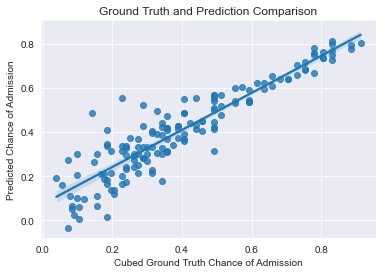

In [34]:
sns.regplot(x=y_test, y=y_test_hat)
plt.xlabel('Cubed Ground Truth Chance of Admission')
plt.ylabel('Predicted Chance of Admission')
plt.title('Ground Truth and Prediction Comparison')

plt.show()

The plot above shows that the model performs better at higher admissions chances than lower admissions chances, as shown by the narrowing in the distribution of points as the rate increases. This is perhaps explained in part by the fact that there is more data for higher admission chances. 

### Residuals
An assumption of linear regression is that the residuals be normally distributed. Whether residuals are well distributed can be shown by plotting the dependent variable against the residuals.

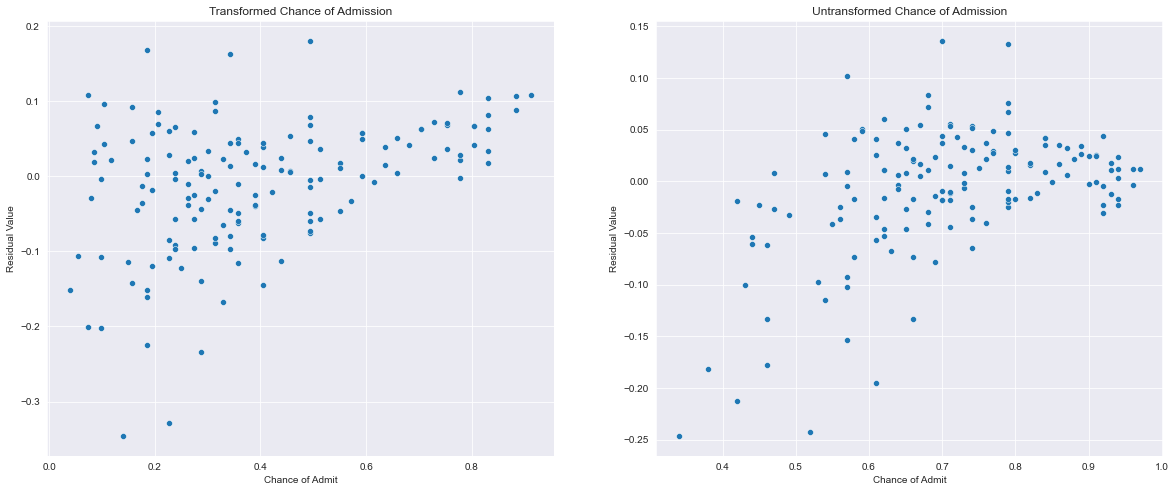

In [35]:
# Train model with untransformed dependent variable
y_train_untransformed = y_train**(1/3)
y_test_untransformed = y_test**(1/3)

# The hyperparameters below were also found using cross validation
en_untransformed = ElasticNet(alpha=0.020235896477251564, l1_ratio=1e-7, random_state=123)
en_untransformed.fit(x_train_scaled, y_train_untransformed)
y_test_untransformed_hat = en_untransformed.predict(x_test_scaled)

residuals = []
untransformed_residuals = []

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for i, prediction in enumerate(y_test_hat):
    residuals.append(y_test.values[i] - prediction)
    untransformed_residuals.append(y_test_untransformed.values[i] - y_test_untransformed_hat[i])

sns.scatterplot(x=y_test, y=residuals, ax=axes[0])
axes[0].set_title('Transformed Chance of Admission')
axes[0].set_ylabel('Residual Value')
sns.scatterplot(x=y_test_untransformed, y=untransformed_residuals, ax=axes[1])
axes[1].set_title('Untransformed Chance of Admission')
axes[1].set_ylabel('Residual Value')

plt.show()

Above it would appear that fitting a model using the untransformed data leads to residuals that suggest both nonlinearity and heteroscedasticity. The transformation did not eliminate the heteroscedasticity, but it does seem to decrease the nonlinearity issue.

### Coefficients

Below are the feature names and corresponding coefficients:
('CGPA', 0.10320136780069232)
('GRE Score', 0.03636982220472103)
('TOEFL Score', 0.03465322786065806)
('University Rating', 0.0218668592566487)
('LOR', 0.01861451288884387)
('SOP', 0.008684241755412016)


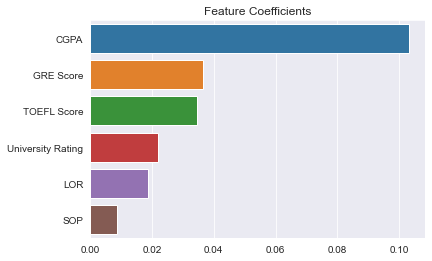

In [36]:
coefficients = en.coef_
features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA']

feature_name_pairs = list(zip(features, coefficients))
feature_name_pairs = sorted(feature_name_pairs, key=lambda x: x[1], reverse=True)

unzipped_feature_name_pairs = list(zip(*feature_name_pairs))
feature_names = unzipped_feature_name_pairs[0]
feature_coefficients = unzipped_feature_name_pairs[1]

sns.barplot(x=list(feature_coefficients), y=list(feature_names), orient='h')
plt.title('Feature Coefficients')

print('Below are the feature names and corresponding coefficients:')
for feature in feature_name_pairs:
    print(feature)

From the above, it is clear that, all else equal, a higher GPA increases the chance of admission into graduate school more than a good GRE score, a good GRE score improves ones chaances more than a good TOEFL score, etc.

# Conclusion

A linear model effectively predicts the chance of admission into a graduate school.